**<center><h1>Semi-Supervised Learning for Automatic Speech Recognition</h1><center/>**

This is an implementation of the paper [Pushing the limits of semi-supervised learning for automatic speech recognition](#ref11)

### **Table of Contents**
1. [Data](#data)<br>
    1.1. [Speech Commands](#speechcommnds)<br>
    1.2. [Word Tokenizer](#wordtoken)<br>
2. [Model Architecture](#modelarch)<br>
3. [Noisy Student Training with SpecAugment](#nst)<br>
    3.1. [SpecAugment](#specaug)<br>
4. [Code](#code)<br>
    4.1. [Definition of tensors](#tdef)<br>
    4.2. [Manipulation of multidimensional signals with tensors](#st)<br>
5. [Results](#results)<br>
    5.1. [Elementwise operations](#ewo)<br>
    5.2. [Dot product](#dot)<br>
    5.3. [Norms](#nor)<br>
7. [References](#ref)<br>

[Appendix](#appendix)<br>

1. [Data](#appdata)<br>
    1.1. [Libri-Light dataset](#librilight)<br>
    1.2. [LibriSpeech dataset](#librispeech)<br>
    1.3. [Word-Piece-Model](#wpm)<br>
2. [Pretraining](#pretraining)<br>
    2.1. [Model Architecture](#premodel)<br>
    2.1. [Loss](#preloss)<br>
3. [Language Model](#lm)<br>


## **1. Data** <a name="data" />

### **1.1. Speech Commands** <a name="speechcommnds" />

Speech commands is a dataset [[13]](#ref13) composed of audios that contain one word commands such as forward, zero, left ecc. Due to hardware constraints, the model had to be sized down and the datasets Libri-Light [[6]](#ref6) and LibriSpeech [[7]](#ref7) used in the paper [[12]](#ref12)  have been placed with the current one. Initially I used the SpokenDigit [[5]](#ref5) dataset for the Noisy Student Training (NST) (which is used in the fine-tuning phase described in Sec. [3](#nst)). Since this includes only digits the labels are a very small subset of the labels present in the speechcommads' dataset which is composed of 35 different commands, I opted to split the latter in two parts. The log-mel spectograms of the audios are given as input to the model and the labels are encoded using a word tokenizer.

### **1.2. Word Tokenizer** <a name="wordtoken" />

The vocabulary maps the words of the train dataset to indices representing their occurrences in the set. The lowest index indicates the most common word in the data. To fit the vocabulary in memory and to make the model more robust to unknown words only the words with the most occurrences are taken into account. In this case we son't have words with very few occurrences.

## **2. Model Architecture** <a name="modelarch" />

The model is based on the on a series of conformers that characterize the encoder as shown in Fig.[1](#fig:model) and a BiLSTM decoder [[3]](#ref3), [[12]](#ref12). In this project is implemented only the model on the left. Due hardware constraints I had to change the LibriLight dataset [[6]](#ref6) used in [[11]](#ref11) with a smaller one. I first used SpokenDigits [[5]](#ref5) and then a portion of SpeechCommands, both are too small for the pretraining to work

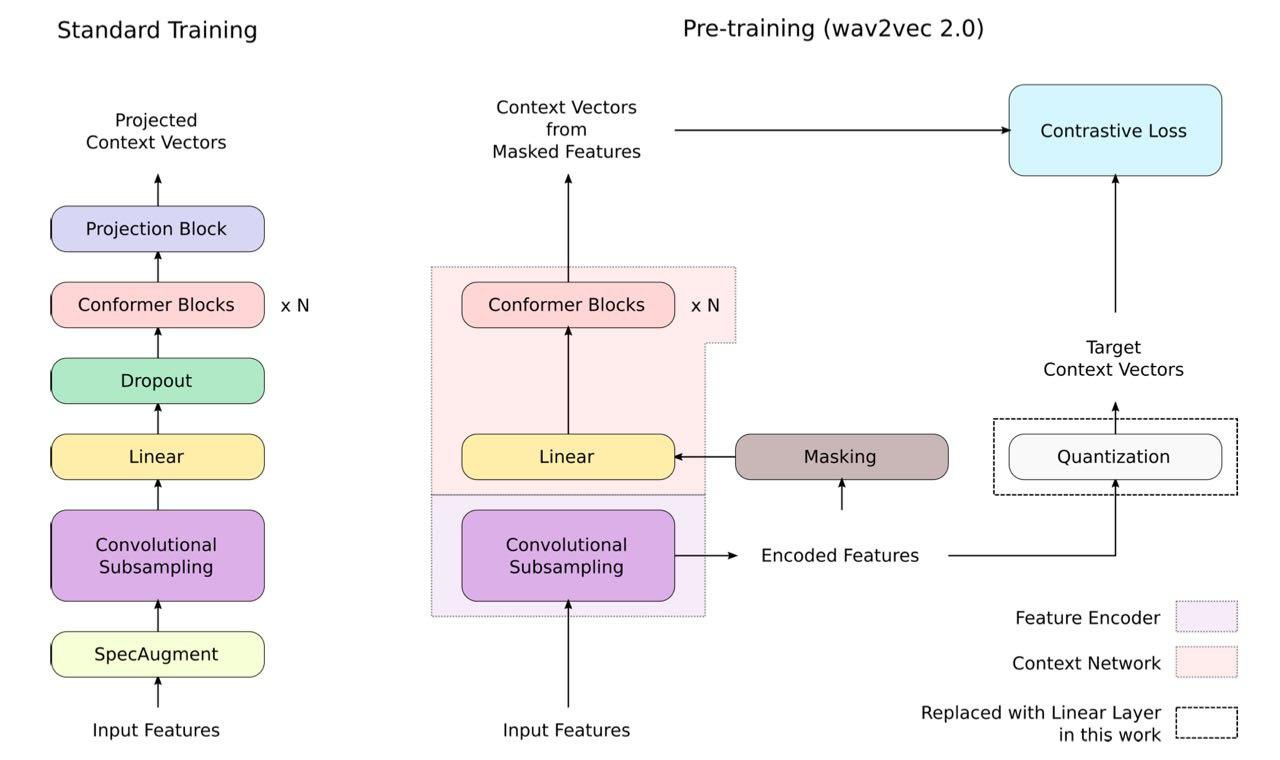 <a name="fig:model"/>

*Fig. 1. The model structure for the stardard training on left and for pretraining on the right*

### **Convolutional Subsampling** <a name="convsub" />


The block has two 2D-convolution layers and produces a reduction of the feature sequence lenght [[12]](#ref12).

### **Conformer** <a name="conformer" />

The model is comprised of a conformer block [[3]](#ref3) structured as depicted in Fig.[2](#fig:conformer). The confermer is formed by a Multi-Head Self-Attention (MHSA) module (Fig.[4](#fig:mhsa)) followed by a Convolution module (Fig.[5](#fig:conv)). Two Feed Forward modules (Fig.[3](#fig:ffn)) with half residual step is added before and after the MHSA and Convolution modules. A final layer norm completes the conformer block.

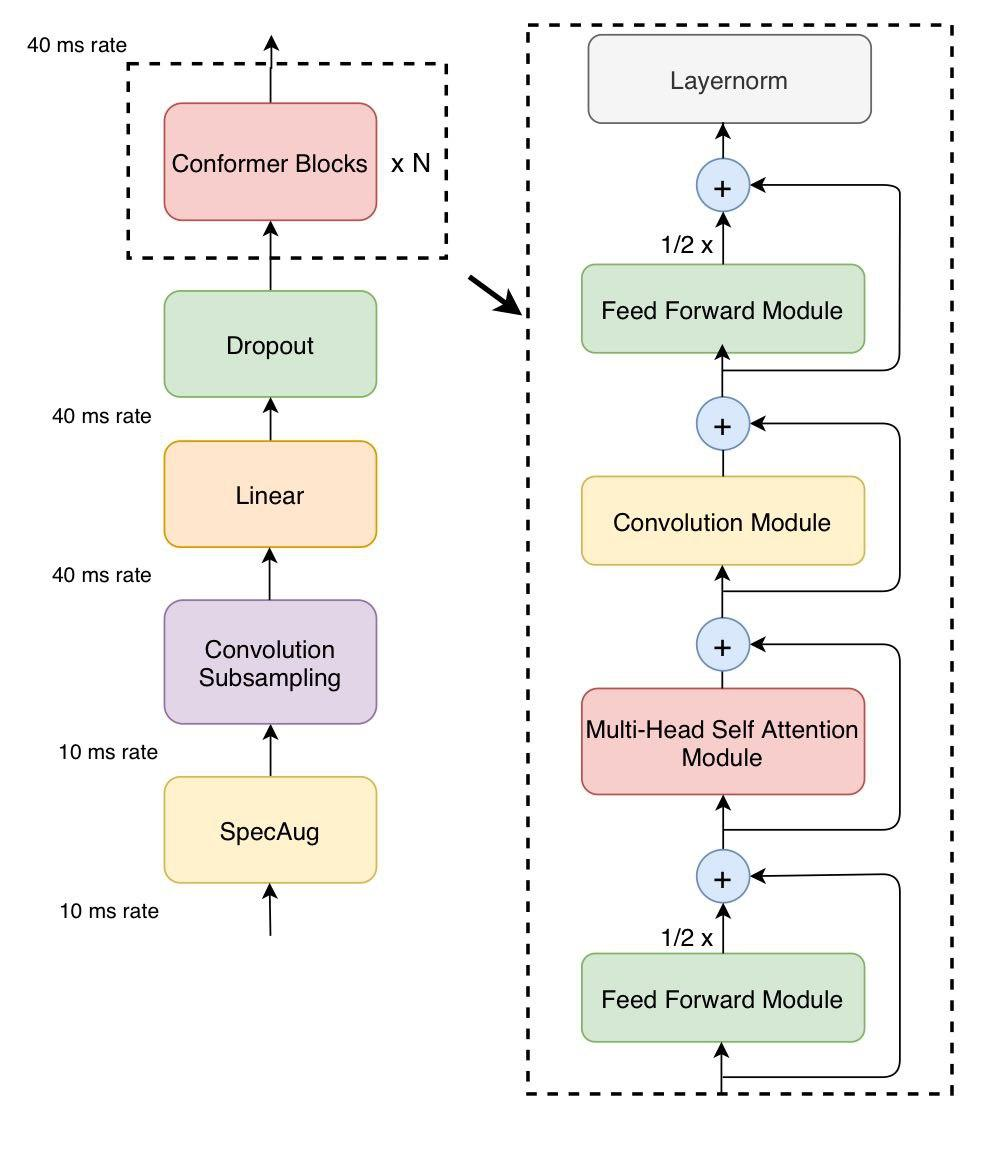 <a name="fig:conformer"/>

*Fig. 2. Conformer model architecture*


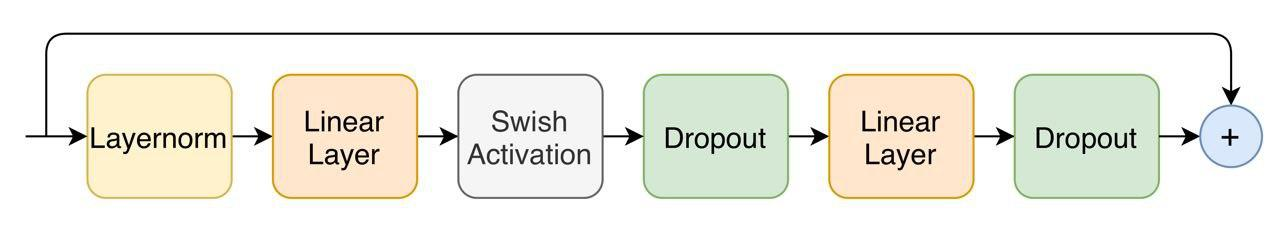<a name="fig:ffn" />

*Fig. 3. FeedForward  Module*

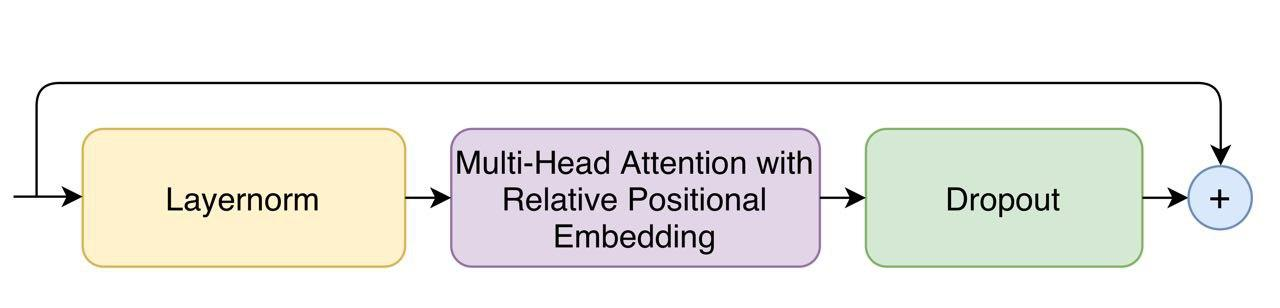 <a name="fig:mhsa"/>

*Fig. 4. Multi-head Self Attention Module*

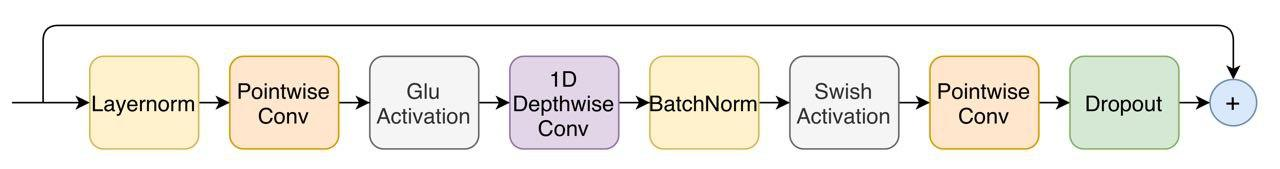 <a name="fig:conv"/>

*Fig. 5. Convolution Module*

### **Projection Block** <a name="proj" />


This block is formed by a linear layer with Swish activation and batch-normalization [[12]](#ref12).


## **3. Noisy Student Training with SpecAugment** <a name="nst" />

<!-- %%% check fusion -->
Noisy student training (NST) [[12]](#ref12) is used to train the speech recognition model. In NST for ASR, a teacher model, obtained by deep-fusing [[4]](#ref4) an ASR model with a language model (LM), is used to generate transcripts for the unlabeled data via inference on un-augmented audio.

With the labeled dataset $S$, the unlabeled dataset $U$ and a LM trained on the LibriSpeech LM corpus and dataset, the following procedure is used to train a series of models:


* Fine-tune pre-trained model $M_0$ on $S$ with SpecAugment. set $M=M_0$.
* Fuse $M$ with LM and measure performance.
* Generate labeled dataset $M(U)$ with fused model.
* Mix dataset $M(U)$ and $S$.
* Fine-tune new pre-trained model $M'$ with SpecAugment on mix dataset.
* Set $M=M'$ and go to 2.

In this implementation of the language model (Sec.[3](#lm) of the appendix) is not needed since the labels are one word commands.


### **3.1. SpecAugment** <a name="specaug"/>

A SpecAugment policy is obtained by applying three basic augmentations a fixed number of times [[8]](#ref8), [[9]](#ref9): time warping, frequency masking and time masking. We denote the time and frequency dimensions of the spectogram as $\tau$ and $\upsilon$.

 * **Time warping with parameter $\mathbf{W}$:** a displacement $w$ is chosen from a uniform distribution from $-W$ to $W$. A start point $w_0$ is chosen from the interval $[W,\tau-W)$. A linear warping function $\mathcal{W}(t)$ is defined so that the boundary points $t=0$ and $t=\tau-1$ are fixed:
\begin{equation*}
        \mathcal{W}(t)=
        \begin{cases}
            % \begin{align*}
                \left(\frac{w_0+w}{w_0}\right)t \ &t\leq w_0, \\
                \frac{(\tau-1-w_0-w)t+(\tau-1)w}{\tau-1-w_0} \ &t>w_0.
            % \end{align*}
        \end{cases}
\end{equation*}
Warping is defined so that the warped features $\mathbf{x}_{warp}(t)$ at time $t$ are related to the original log-mel frequency coefficients $\mathbf{x}_{orig}(t)$ by    
\begin{equation*}
        \mathbf{x}_{warp}(\mathcal{W}(t))=\mathbf{x}_{orig}(t).
\end{equation*}
    

* **Frequency masking with parameter $\mathbf{F}$:** a mask size $f$ is chosen from a uniform distribution form 0 to $F$. The consecutive log-mel-frequency channels $[f_0,f_0+f)$ are then masked, where $f_0$ is chosen from $[0,\upsilon-f)$.
* **Time masking with parameter $\mathbf{T}$:** a mask size $t$ is chosen from a uniform distribution from 0 to $T$. The consecutive time steps $[t_0,t_0+t)$ are masked, where $t_0$ is chosen from $[0,\tau-t)$.

**Adaptive masking**

In large datasets there may be large variances in the length of the input audio. Thus, a fixed number of time masks may be too weak for longer utterances, or too severe for shorter ones. To solve this problem there adaptive time masking can be done in two different ways with respect to the length of the spectogram $\tau$ [[9]](#ref9):

* **Adaptive multiplicity:** the number of time masks $M_{\text{t-mask}}$ is set to be $M_{\text{t-mask}}=\lfloor p_M\cdot\tau\rfloor$, where $p_M$ is the multiplicity ratio.
* **Adaptive size:** the mask parameter is set to be $T=\lfloor p_S\cdot\tau \rfloor$ for the size ratio $p_S$.

In this paper a minimum of 10 time masks are performed:

\begin{equation*}
    M_{\text{t-mask}}=\min(10,\lfloor p_M\cdot\tau\rfloor)
\end{equation*}

# **4. Code** <a name="code"/>

Some libraries are imported

In [3]:
import os
from lib.hparams import HParams
from lib.standard.speechcommands import SpeechCommands
from lib.standard.runner import Runner

The path to the project folder is initialized

In [4]:
nn_dir='.'

Initialization of the class of hyperparameters

In [5]:
hp=HParams(nn_dir)

Gathering the data

In [6]:
speech=SpeechCommands(hp)

Pretrain: 100%|██████████| 21503/21503 [02:54<00:00, 123.00audio/s]


Initialization of a model. If only the Noisy Student Training is to be performed then it loads the weights of the standard training, otherwise it trains the model. Finally the model is tested on validation (this is also tested at the end of every epoch) and test sets.

In [ ]:
from lib.standard.asrnn import ASRNN
asrnn=ASRNN(hp)
runner=Runner(asrnn,hp)
if not hp.just_nst:
    print()
    print('---------------------------')
    print('     Standard training')
    print('---------------------------')
    print()
    if hp.do_pretraining or hp.load_pretraining: runner.load_model(hp.pretrained_model_path)
    runner.train(speech,hp.epochs,False)
else:
    import torch
    asrnn.load_state_dict(torch.load('/content/drive/MyDrive/nn22/model/standard_weights.pth'))

runner.test(speech,'validation',heatmap=True)
runner.test(speech,'test',heatmap=True)

The model is fine-tuned by using Noisy Student Training with SpecAugment

In [ ]:
if hp.lm or hp.nst or hp.just_nst:
    from lib.finetuning.finetune import FineTune
    print()
    print('---------------------')
    print('     Fine tuning')
    print('---------------------')
    print()
    tune=FineTune(hp)
    tunerunner=tune.fine_tuning(asrnn,speech,speech)

Finally the finetuning model is tested on validation and test sets.

In [ ]:
runner.test(speech,'validation',heatmap=True,finetuning=True)
runner.test(speech,'test',heatmap=True,finetuning=True)


# **5. Results** <a name="results"/>

The heatmap below shows that the words with the highest error rate are also the less represented words. This is because the training set is highly unbalanced. A possible solution is by creating new samples by drawing them from the dataset and adding gaussian noise to these. Note that the underscore indicates the extra words predicted from the model.

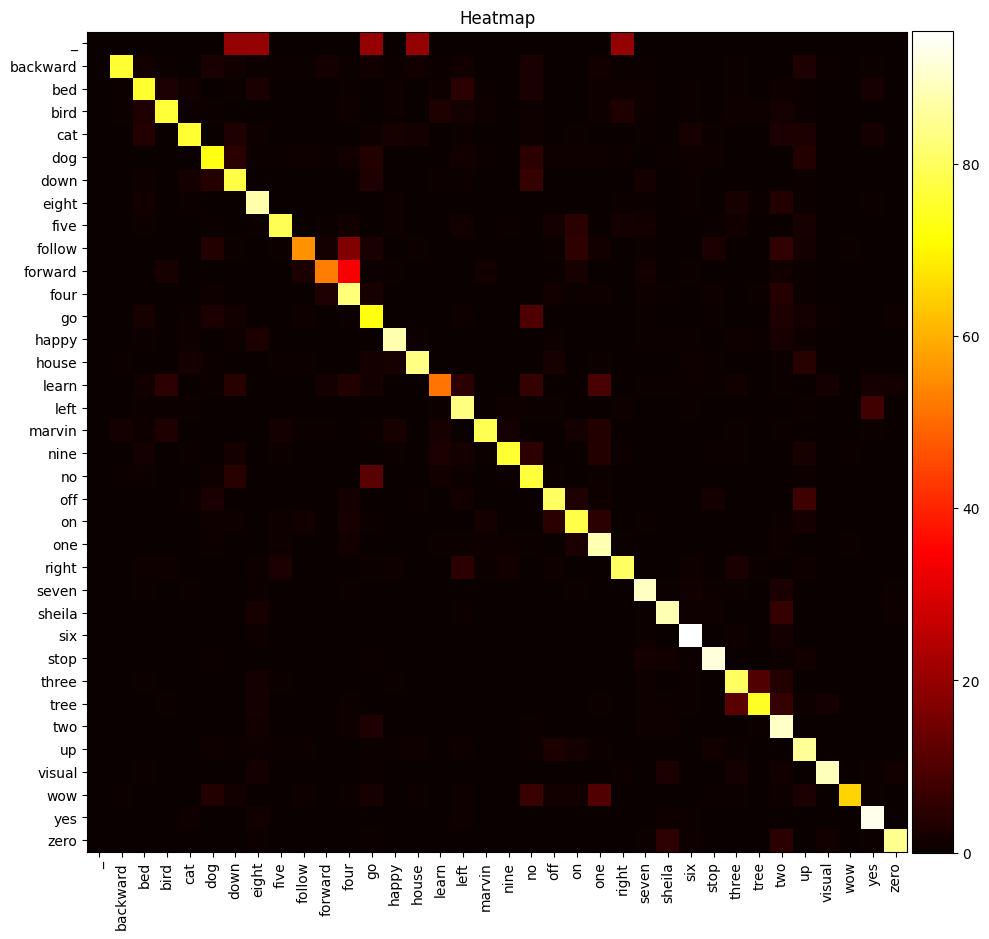

*Fig. 6. Heatmap of the test results from the base model*

The following table show the final results of the experiments. The base model corresponds the model with just standard training. As previously mentioned, the data is quite unbalanced and augmented samples could be added to the dataset. Due to the mole of the needed augmented samples (some words have less than half samples than the ones of other words), the model performes worse.
The last three experiments show how the noisy student training decreases the error rate. In this case it works better without adaptive masking. The results may differ greatly if the dataset were to be balanced and greater in size.

| Model      | Validation | Test |
| ----------- | ----------- | |
| Base      | 17.02       | 18.77 |
| Balanced   | 28.99        | 29.36 |
| NST   | **16.23**        | **18.08** |
| NST+adapt.mult.   | 16.78        | 18.73 |
| NST+adapt.mult.+adapt.size   | 16.55        | 18.38 |

As we can see in the following image, the heatmap of the results after fine-tuning are very similar to one before it. This is to the due the very similar results.

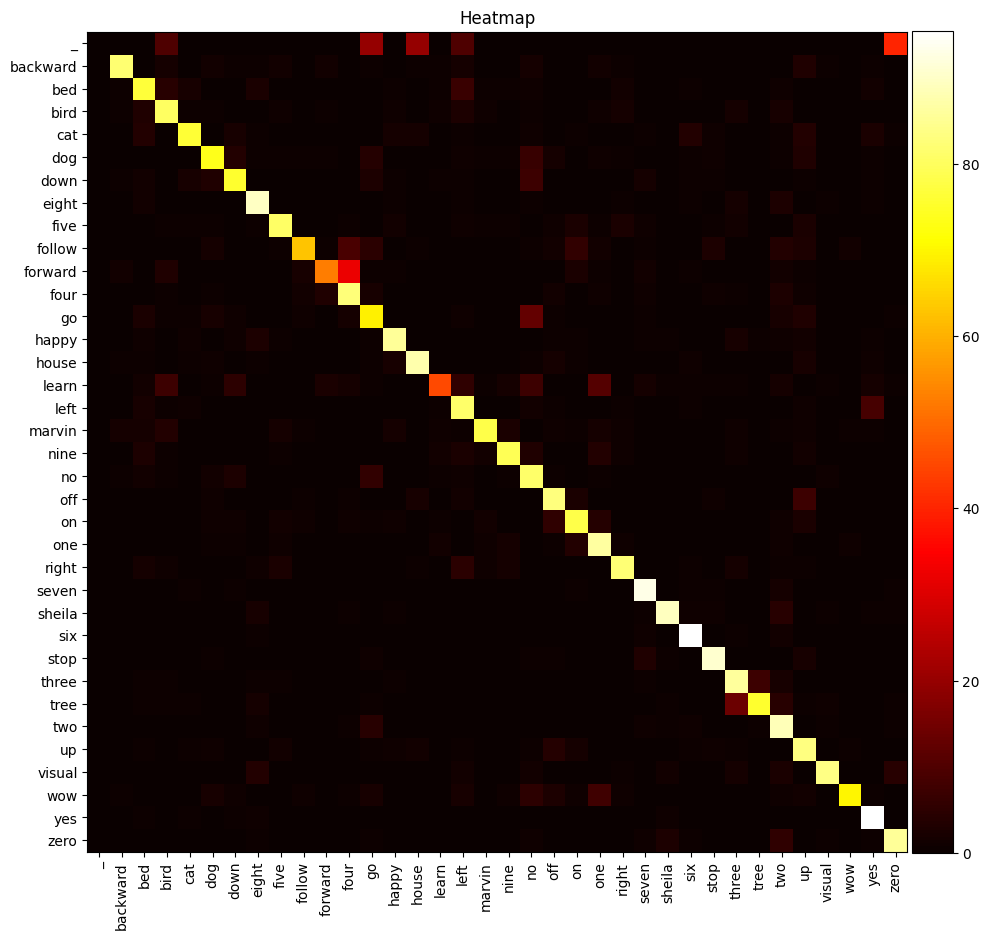

*Fig. 7. Heatmap of the test results after fine-tuning.*

# **6. References** <a name="ref" />

[1] Alexei Baevski, Henry Zhou, Abdelrahman Mohamed,
and Michael Auli. 2020. wav2vec 2.0: A framework for self-supervised learning of speech representations. <a name="ref1" />

[2] Zihang Dai, Zhilin Yang, Yiming Yang, Jaime Car-
bonell, Quoc V. Le, and Ruslan Salakhutdinov. 2019.
Transformer-xl: Attentive language models beyond a
fixed-length context.  <a name="ref2" />

[3] Anmol Gulati, James Qin, Chung-Cheng Chiu, Niki
Parmar, Yu Zhang, Jiahui Yu, Wei Han, Shibo Wang,
Zhengdong Zhang, Yonghui Wu, and Ruoming Pang. 2020. Conformer: Convolution-augmented transformer for speech recognition.  <a name="ref3" />

[4] Caglar Gulcehre, Orhan Firat, Kelvin Xu, Kyunghyun
Cho, Loic Barrault, Huei-Chi Lin, Fethi Bougares,
Holger Schwenk, and Yoshua Bengio. 2015. On
using monolingual corpora in neural machine translation.  <a name="ref4" />

[5] Zohar Jackson. 2016. Spokendigit. <a name="ref5" />

[6] J. Kahn, M. Rivière, W. Zheng, E. Kharitonov, Q. Xu,
P. E. Mazaré, J. Karadayi, V. Liptchinsky, R. Collobert, C. Fuegen, T. Likhomanenko, G. Synnaeve, A. Joulin, A. Mohamed, and E. Dupoux. 2020. Libri-light: A benchmark for asr with limited or no supervision. In ICASSP2020-2020 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP),
pages 7669–7673. https://github.com/
facebookresearch/libri-light.  <a name="ref6" />

[7] Vassil Panayotov, Guoguo Chen, Daniel Povey, and San-
jeev Khudanpur. 2015. Librispeech: An asr corpus
based on public domain audio books. In 2015 IEEE
International Conference on Acoustics, Speech and
Signal Processing (ICASSP), pages 5206–5210.  <a name="ref7" />

[8] Daniel S. Park, William Chan, Yu Zhang, Chung-Cheng
Chiu, Barret Zoph, Ekin D. Cubuk, and Quoc V. Le.
2019a. SpecAugment: A simple data augmentation
method for automatic speech recognition. In Interspeech 2019. ISCA  <a name="ref8" />

[9] Daniel S. Park, Yu Zhang, Chung-Cheng Chiu,
Youzheng Chen, Bo Li, William Chan, Quoc V. Le,
and Yonghui Wu. 2019b. Specaugment on large scale
datasets.  <a name="ref9" />

[10] Mike Schuster and Kaisuke Nakajima. 2012. Japanese
and korean voice search. In International Conference
on Acoustics, Speech and Signal Processing, pages
5149–5152.  <a name="ref10" />

[11] Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob
Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz
Kaiser, and Illia Polosukhin. 2017. Attention is all
you need.  <a name="ref11" />

[12] Yu Zhang, James Qin, Daniel S. Park, Wei Han, Chung-Cheng Chiu, Ruoming Pang, Quoc V. Le, and
Yonghui Wu. 2020. Pushing the limits of semi-supervised learning for automatic speech recognition  <a name="ref12" />

[13] Pete Warden. 2018. Speech commands: A dataset
for limited-vocabulary speech recognition. CoRR,
abs/1804.03209. <a name="ref13" />

# **Appendix** <a name="appendix"/>

The models and datasets in [[12]](#ref12) are quite complex. Thus, the project had to be scaled down due to hardware constraints. I did implement them at the beginning to try and make them work regardless without success. Note authors of the paper [[12]](#ref12) used 256/512 GB GPUs, the models runned for days with tens of thousands of epochs and the results started to be significant after few thousands epochs.

## **1. Data** <a name="appdata"/>

### **1.1. Libri-Light dataset** <a name="librilight"/>

This work uses the utterances from the "unlab-600" subset of Libri-Light [[6]](#ref6) containing 577h of unlabeled audio to pre-train the conformer. The model in Fig.[[1]](#fig:model) takes as as inputs the normalized log-mel spectograms of the raw waveforms of the segmented data. The original long audios are segmented to fit into memory and to keep only voice activity.

### **1.2. LibriSpeech dataset** <a name="librispeech"/>

The dataset [[7]](#ref7) is compound of the raw waveforms and their voice activity transcriptions. As in Appendix Sec.[1.1](#librilight) the log-mel spectograms are extracted and fed to the standard model (Sec.[2](#modelarch), Fig.[1](#fig:model)). The transcripts are tokenized in two different ways: a simple word tokenizer and a Word-Piece-Model (WPM).

### **1.3. Word-Piece-Model** <a name="wpm"/>

WPM [[10]](#ref10) augments the data by introducing the character n-grams of the words. The previous work suggest to take n-grams of 3-5 characters or until the likelihood of these goes under a certain threshold since both Japanese and Korean language may or may not have spaces between consecutive words. This work focuses on the English language were words are all always separated by spaces or punctuation, thus all possible n-grams are considered at first. Similarly from Sec.[1.2](#wordtoken) these are ordered by their frequency and only the first 1024 tokens are kept. This enables to have an infinity vocabulary that represents any possible word with a small amount of tokens.

## **2. Pretraining** <a name="pretraining"/>

### **2.1. Model Architecture** <a name="premodel"/>


The model is depicted on the right of Fig. [[1]](#fig:model).

**Masking**

The encoded features are masked with probability 0.065 and given as input to the Context Network.

**Quantization**

The simplified version developed by [[12]](#ref12) replaces the quantization module with a Linear layer. This paper investigates the results of applying the Gumbel softmax to the Linear output [[1]](#ref1). Discrete codebook entries are chosen in a fully differential way by the Gumbel softmax. Given $G$, the number of hard Gumbel operations, the probabilities for choosing the $v$-th codebook entry for group $g$ are

\begin{equation}
    p_{g,v}=\frac{\exp(l_{g,v}+n_v)/\tau}{\sum_{k=1}^V \exp(l_{g,k}+n_k)/\tau}
\end{equation}

where $\tau$ is a non-negative temperature, $n=-\log(-\log(u))$ and $u$ are uniform samples from $\mathcal{U}(0,1)$.

### **2.2. Loss** <a name="preloss"/>



During pre-training, in the simplified version [[12]](#ref12) a contrastive loss $\mathcal{L}_m$ is solved to learn speech audio representations. It requires to identify the true quantized latent speech representation for a masked time step within a set of distractors. In this work the loss is augmented by a codebook diversity loss $\mathcal{L}_d$ to encourage the model to use the codebook entries equally often [[1]](#ref1).

\begin{equation}
    \mathcal{L}=\mathcal{L}_m+\alpha\mathcal{L}_d
\end{equation}

where $\alpha$ is a tuned hyperparameter.

**Contrastive Loss**

The contrastive task depends on the codebook to represent both positive and negative examples.
Given a context network output $\mathbf{c}_t$ centered over masked time step $t$, the model needs to identify the true quantized latent speech representation $\mathbf{q}_t$ in a set of $K+1$ quantized candidate representations $\mathbf{\tilde{q}}\in\mathbf{Q}_t$ which includes $\mathbf{q}_t$ and $K$ distractors. Distractors are uniformly sampled from other masked time steps of the same utterance. The loss [[1]](#ref1) is defined as

\begin{equation}
    \mathcal{L}_m=-\log\frac{\exp(sim(\mathbf{c}_t,\mathbf{q}_t)/\kappa)}{\sum_{\mathbf{\tilde{q}}\sim\mathbf{Q}_t}\exp(sim(\mathbf{c}_t,\mathbf{\tilde{q}})/\kappa)}
\end{equation}

where $sim(a,b)$ is the cosine similarity between context representations and quantized latent speech representations (Fig.[1](#fig:model)).

**Diversity Loss**

The diversity loss $\mathcal{L}_d$ is designed to increase the use of the quantized codebook representations. Equal use of the $V$ entries in each of the $G$ codebooks is encouraged by maximizing the entropy of the averaged softmax distribution over the codebook entries for each codebook $\bar{p}_g$ across a batch of utterances [[1]](#ref1):

\begin{equation}
    \mathcal{L}_d=\frac{1}{GV}\sum_{g=1}^G-H(\bar{p}_g)=\frac{1}{GV}\sum_{g=1}^G\sum_{v=1}^V\bar{p}_{g,v}\log\bar{p}_{g,v}
\end{equation}

# **3. Language Model** <a name="lm"/>

A Language model [[2]](#ref2) computes the probability of a word or token to appear in a dataset given the context. The data is a combination of the LibriSpeech dataset transcripts and the LibriSpeech LM corpus [[7]](#ref7). The Input embeddings are the embeddings of the words pronunciations whereas the output embeddings correspond to the words embeddings. Here it is used the model architecture from [[11]](#ref11).

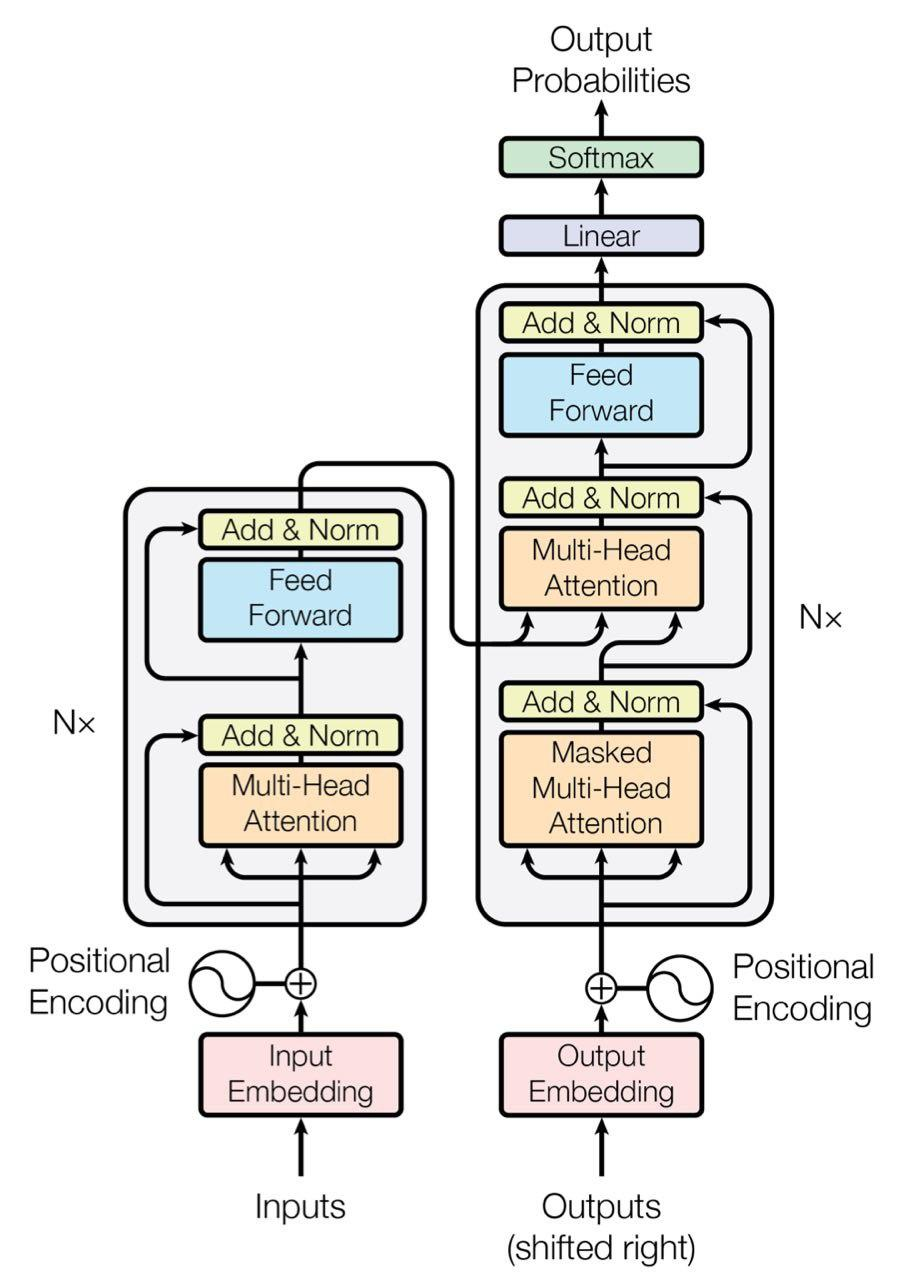 <a name="fig:lm"/>

*Fig. 8. Language Model architecture*